In [1]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
data = pd.read_excel('./data/index_Infomation.xlsx')
df = data[['Date', 'samsung_Close']]

# 전체 데이터 중 80%를 훈련데이터로, 20%를 테스트 데이터로 나누기
df.set_index('Date', inplace=True)
train_size = int(len(df) * 0.8)
train = df['samsung_Close'][:train_size]
test = df['samsung_Close'][train_size:]

In [ ]:
# Exponential Smoothing 모델 초기화
model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

In [4]:
# 하이퍼파라미터 옵션 설정
param_grid = {
    'trend': [None, 'add', 'mul'],  # 트렌드(추세) 옵션: 없음, 덧셈적, 곱셈적. 
    'seasonal': [None, 'add', 'mul'],  # 계절성 옵션: 없음, 덧셈적, 곱셈적
    'seasonal_periods': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],  # 계절성 주기: None ~ 12
    'damped_trend': [True, False],  # 댐핑된 트렌드 사용 여부
}

In [ ]:
# 최적의 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))
        
        # 평가지표
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        # MSE 기준으로 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

In [7]:
# 결과 출력
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

Best Parameters: {'damped_trend': False, 'seasonal': 'add', 'seasonal_periods': 11, 'trend': 'add'}
Best MSE: 38813472.27220741
Best Metrics: {'MSE': 38813472.27220741, 'MAE': 5049.258836047029, 'MAPE': 0.07988447128531527, 'R²': 0.2991560635556908}


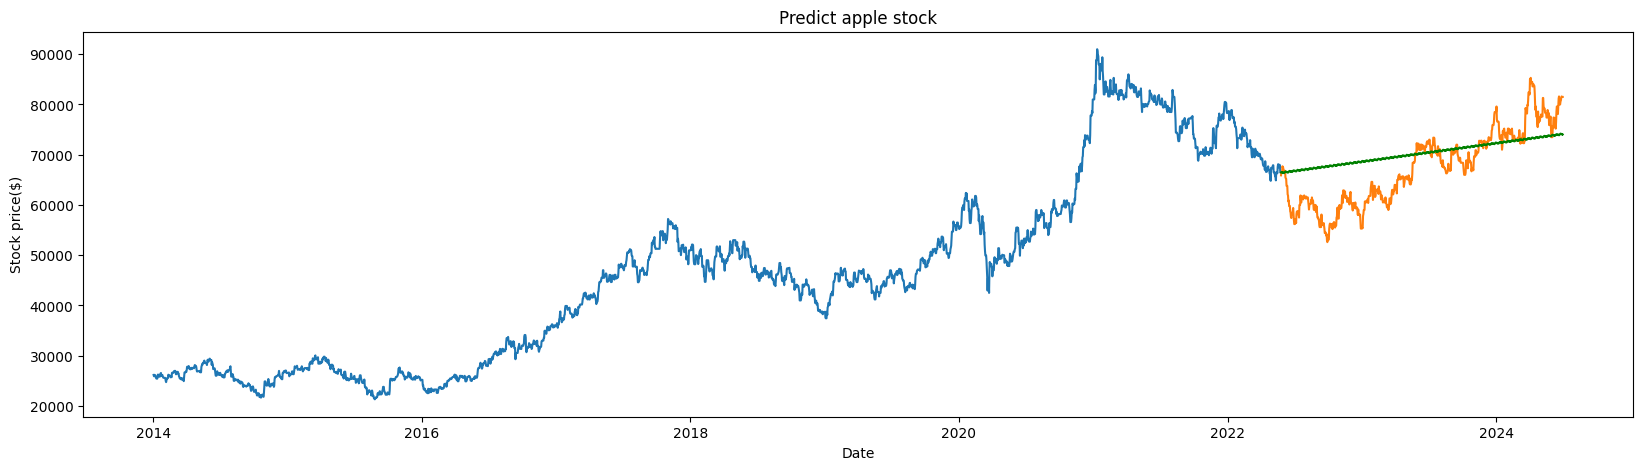

In [8]:
# 최적모델 예측 시각화

# 인덱스 데이터타입 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict apple stock')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.show()

In [ ]:
# 축소 학습 예측

# 기간 축소
sort_df = df.loc['2024-03-01' : '2024-06-30']

# 훈련, 테스트 데이터 나누기
train_size = int(len(sort_df) * 0.75)
train = sort_df['samsung_Close'][:train_size]
test = sort_df['samsung_Close'][train_size:]

# 파라미터 옵션 설정
param_grid = {
    'trend': [None, 'add', 'mul'],
    'seasonal': [None, 'add', 'mul'],
    'seasonal_periods': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'damped_trend': [True, False],
}

# 하이퍼파라미터 초기화
best_score = float('inf')
best_params = None
best_model = None

# 그리드 서치 수행
for params in ParameterGrid(param_grid):  # ParameterGrid를 통한 파라미터 조합 생성
    try:
        # 모델 생성 및 학습
        model = ExponentialSmoothing(
            train,
            trend=params['trend'],
            seasonal=params['seasonal'],
            seasonal_periods=params['seasonal_periods'],
            damped_trend=params['damped_trend']
        ).fit()

        # 예측
        predictions = model.forecast(len(test))
        
        # 평가지표
        mse = mean_squared_error(test, predictions)
        mae = mean_absolute_error(test, predictions)
        mape = mean_absolute_percentage_error(test, predictions)
        r2 = r2_score(test, predictions)
        
        # MSE 값을 기준으로 최적모델 저장
        if mse < best_score:
            best_score = mse
            best_params = params
            best_model = model
            best_metrics = {
                'MSE': mse,
                'MAE': mae,
                'MAPE': mape,
                'R²': r2
            }

    except Exception as e:
        print(f"Error with parameters {params}: {e}")

In [10]:
# 결과 출력
print("Best Parameters:", best_params)
print("Best MSE:", best_score)
print("Best Metrics:", best_metrics)

Best Parameters: {'damped_trend': True, 'seasonal': 'mul', 'seasonal_periods': 6, 'trend': 'mul'}
Best MSE: 923547.7929318568
Best Metrics: {'MSE': 923547.7929318568, 'MAE': 748.7389084049261, 'MAPE': 0.009670264402204934, 'R²': 0.8608896763958354}


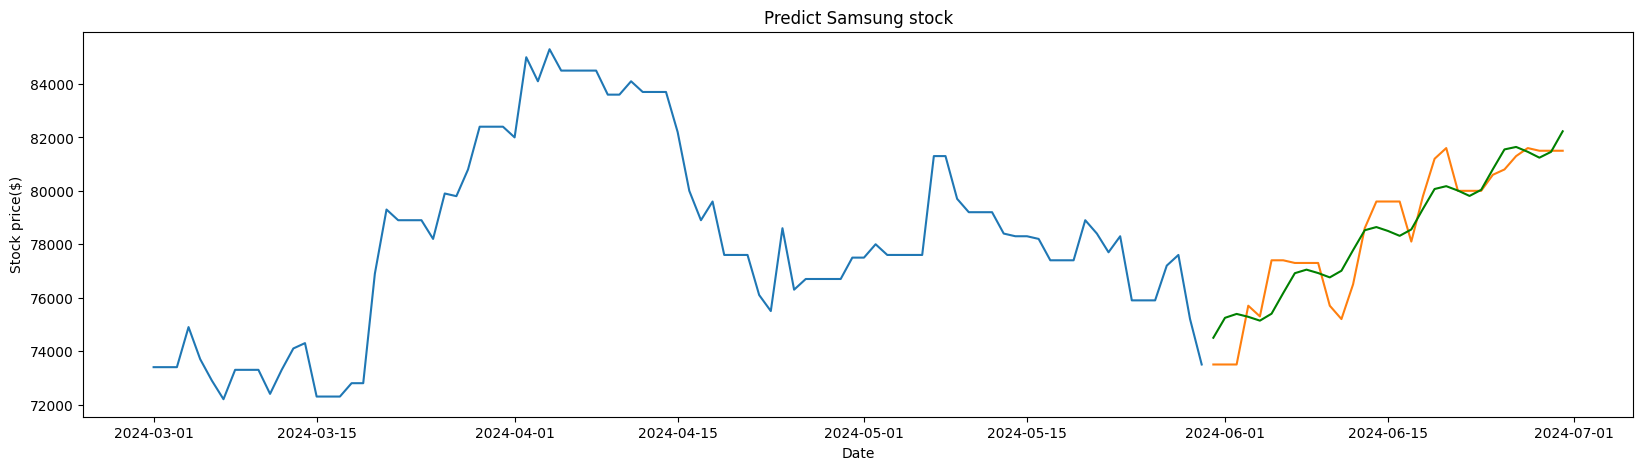

In [11]:
# 최적 모델을 사용한 예측 시각화

# 인덱스 데이터타입 변경
train.index = pd.to_datetime(train.index)
test.index =  pd.to_datetime(test.index)

# 그래프 그리기
plt.figure(figsize=(20, 5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, best_model.forecast(len(test)), label='Forecast', color='g')

# 그래프 제목 및 레이블 설정
plt.title('Predict Samsung stock')
plt.xlabel('Date')
plt.ylabel('Stock price($)')

plt.show()

In [ ]:
# 학습, 테스트 크기 설정
window_size = 21  # 3주 학습
test_size = 7    # 1주 테스트

# 예측 결과를 저장할 데이터프레임 초기화
results_df = pd.DataFrame(columns=['Date', 'Actual', 'Predicted'])

for start in range(0, len(df) - window_size - test_size + 1, test_size):
    train_data = df['samsung_Close'][start:start + window_size]
    test_data = df['samsung_Close'][start + window_size:start + window_size + test_size]

    # 모델 생성 및 훈련
    model = ExponentialSmoothing(
        train_data,
        trend=None,
        seasonal=None,
        seasonal_periods=None,
        damped_trend=False
    ).fit()

    # 예측
    prediction = model.forecast(len(test_data))

    # 평가지표
    mse = mean_squared_error(test_data, prediction)
    mae = mean_absolute_error(test_data, prediction)
    mape = mean_absolute_percentage_error(test_data, prediction)
    r2 = r2_score(test_data, prediction)
    

    # 결과를 데이터프레임에 저장
    temp_df = pd.DataFrame({
        'Date': test_data.index,
        'Actual': test_data.values,
        'Predicted': prediction,
        'MSE': mse,
        'MAE': mae,
        'MAPE': mape,
        'R²': r2
    })

    results_df = pd.concat([results_df, temp_df])

In [51]:
# 결과 출력
print('MSE:', np.mean(results_df['MSE']))
print('MAE:', np.mean(results_df['MAE']))
print('MAPE:', np.mean(results_df['MAPE']))
print('R2:', np.mean(results_df['R²']))

MSE: 1705364.2845289372
MAE: 926.6744136070067
MAPE: 0.018869825053417624
R2: -15.052506286292344


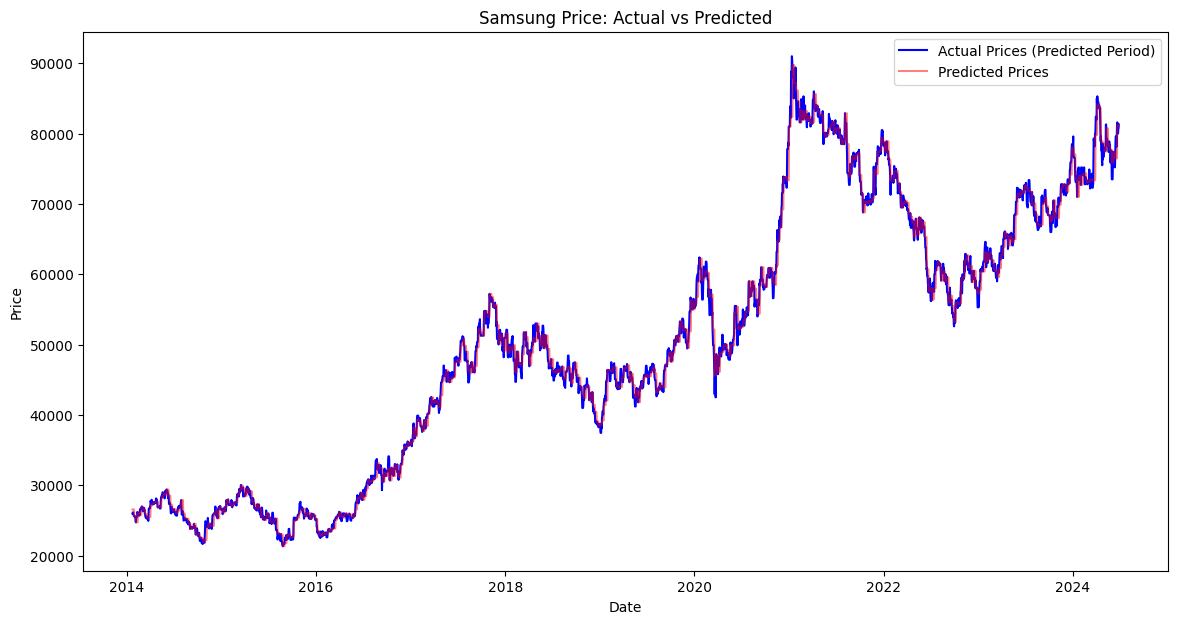

In [52]:
# 단기 예측 시각화

# 인덱스 데이터타입 변경
train_data.index = pd.to_datetime(train_data.index)
test_data.index =  pd.to_datetime(test_data.index)

plt.figure(figsize=(14, 7))

# 실제 전체 주가
# plt.plot(df.index, df['samsung_Close'], label='Actual Prices (Full)', color='blue', linestyle='--')

# 예측 주가 부분만 비교하는 그래프
plt.plot(results_df.index, results_df['Actual'], label='Actual Prices (Predicted Period)', color='blue')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted Prices', color='red', alpha=0.5)

plt.title('Samsung Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

plt.show()

In [ ]:
# 모델 저장
with open('pastGraphRegression_apple_exponentialSmoothing.pkl', 'wb') as file:
    pickle.dump(model, file)